In [1]:
# Check Sumbarine Melt (Qsm)
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import os
import gsw
import Functions as fun

In [2]:
path1 = '/Volumes/T7 Shield/MITgcm_jorgemontt/Qsg150_wind/'
path2 = '/Volumes/T7 Shield/MITgcm_jorgemontt/Qsg150_rep_wind/'
path3 = '/Volumes/T7 Shield/MITgcm_jorgemontt/Qsg150_wind_notide/'
path4 = '/Volumes/T7 Shield/MITgcm_jorgemontt/Qsg150_wind1_nBathy/' # Removed near glacier spike
path5 = '/Volumes/T7 Shield/MITgcm_jorgemontt/Qsg150_wind1_nSill/'
path6 = '/Volumes/T7 Shield/MITgcm_jorgemontt/Qsg150_Wind1_S/'
path7 = '/Volumes/T7 Shield/MITgcm_jorgemontt/Qsg150_Wind1_NS/'

taum1 = np.array([-0.2, -0.1, 0, 0.1, 0.2, -0.3, -0.4, 0.3, 0.4, -0.8, 0.8, -1.5, 1.5]) # maximum wind stress (single event)
taum2 = np.array([-0.2, -0.1, 0.1, 0.2, -0.3, -0.4, 0.3, 0.4, -0.8, 0.8]) # maximum wind stress (repeated events)
taum3 = np.array([0, 0.1, 0.3, 0.8, 1.5]) # No-tide cases
taum4 = np.array([0, 0.1, 0.3, 0.9, 1.5, -0.1, -0.3, -0.9, -1.5])
taum5 =taum4
taum6 = np.array([0, 0.1, 0.3, -0.1, -0.3])
taum7 = taum6

## Wind Forcing

In [3]:
# Zonal Wind Stress
externForcingCircle = 30*86400 # Forcing period in second
externForcingPeriod = 0.25*86400 # time interval between forcing field records
nt = int(externForcingCircle / externForcingPeriod)
model_time = np.linspace(0,externForcingCircle,nt+1);
up = 0*86400 / externForcingPeriod
down = 2.5*86400 / externForcingPeriod
ramp = 0.5*86400 / externForcingPeriod
#taum = taum1.copy() # maximum wind stress
#taum = taum2.copy()
#taum = taum3.copy()
taum = taum7.copy()
zonal_wind_stress = np.zeros((len(taum),nt))

nf = int(down+ramp)
forcing = np.zeros((len(taum),nf))

for i in range(0,len(taum)):
    tau = taum[i]
    for j in range(nf):
        if j <= up - 1:
            forcing[i, j] = 0
        elif j < up + ramp - 1:
            forcing[i, j] = tau * (j - (up - 1)) / ramp
        elif j > down-1:
            forcing[i, j] = tau * (down + ramp - 1 - j) / ramp
        else:
            forcing[i, j] = tau

zonal_wind_stress[:,:nf] = forcing

rt = 1 # number of repeated wind events

zonal_wind_stress[:,:nf*rt] = np.tile(forcing, rt)

wind = np.concatenate((np.zeros((len(taum),1)), zonal_wind_stress), axis=1)

## Submarine Melting
## Near-glacier Temperature & Stratification

In [4]:
# Down-fjord wind
# Taux = [0, 0.1, 0.3, 0.8, 1.5]
#caseid = [3,4,8,11,13]
#caseid = [3,7,10]
#caseid = [1,2,3,4,5]
#caseid = [1,2,3,4,5]

# Up-fjord wind
#caseid = [3,2,6,10,12]
#caseid = [2,5,9]
#caseid = [1,6,7,8,9]

caseid = [1,2,3,4,5]

zrange = [0, -400] # Depth range to calculate Qsm, Temp, and Nsq
Qsm = []
Temp_ng = []
Nsq_ng = []
for i in caseid:
    diagT, qsm, qsmz = fun.Qsm(path6,i,zrange)
    Temp, Nsq = fun.Qsm_depend(path6,i,zrange)
    Qsm.append(qsm)
    Temp_ng.append(Temp)
    Nsq_ng.append(Nsq)

Qsm1 = []
Temp_ng1 = []
Nsq_ng1 = []
for i in caseid:
    diagT1, qsm1, qsmz1 = fun.Qsm(path7,i,zrange)
    Temp1, Nsq1 = fun.Qsm_depend(path7,i,zrange)
    Qsm1.append(qsm1)
    Temp_ng1.append(Temp1)
    Nsq_ng1.append(Nsq1)

In [ ]:
from scipy.interpolate import interp1d
# Original time points
day = np.linspace(60.25, 90, 120)  # Adjust this according to your actual time array

# New time points for hourly data
new_day = np.linspace(60, 90, 721)  # Every hour from 0 to 24

# Interpolation
Qsm_hourly = []
for i in range(len(caseid)):
    interpolator = interp1d(day, Qsm[i], kind='linear',fill_value="extrapolate")  # You can also use 'cubic' or 'quadratic'
    Qsm_interp = interpolator(new_day)
    Qsm_hourly.append(Qsm_interp)

In [ ]:
grid = xr.open_dataset(path1+'grid_003.nc')
area = grid.drF * grid.dyF * grid.HFacC
#file = file0.isel(Xp1=slice(201), Y=slice(35, 45), Yp1=slice(35, 45))
#ds = file.sel(Z=slice(-30))
#ds.T.data/86400


In [ ]:
len(model_time)

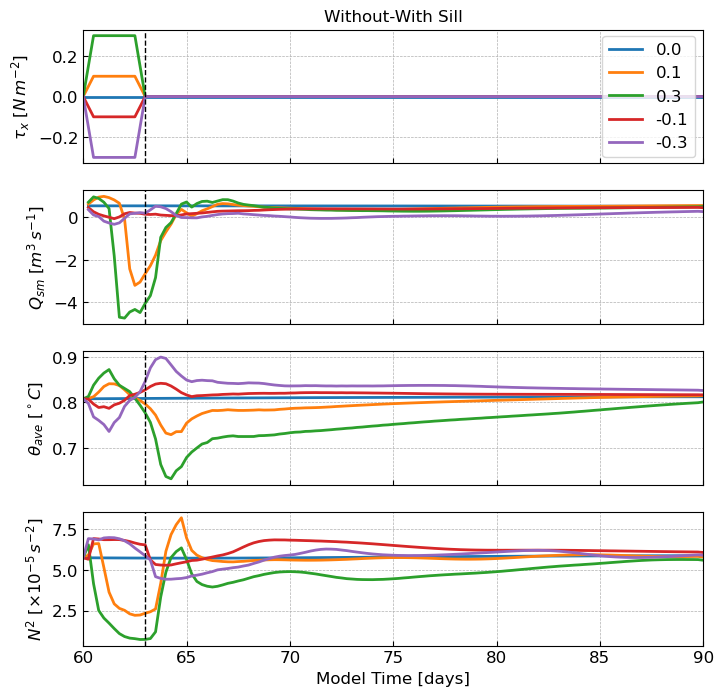

In [9]:
# Time Series
fig0, (ax1, ax2, ax3, ax4) = plt.subplots(4,1, sharex=True, figsize=(8,8))

for i in caseid:
    ax1.plot(model_time/86400+60,wind[i-1,:],lw=2,label=str(taum[i-1]))

ax1.legend(loc='right',fontsize=12)
ax1.set_xlim([60, 90])
#ax1.set_ylim([-.1, .25])
#ax1.set_yticks([8.5,9,9.5,10])
ax1.set_title(r'Without-With Sill', size=12)
ax1.set_ylabel(r'$\tau_x$ [$N\,m^{-2}$]',fontsize=12)
ax1.tick_params(direction='in', labelsize=12)
ax1.grid(linestyle = '--', linewidth = 0.5)

#model_day = 
for j in range(len(caseid)):
    #ax2.plot(diagT/86400, fun.filt_godin(Qsm_hourly[j]), lw=2)
    # ax2.plot(np.linspace(60,90,721), fun.filt_godin(Qsm_hourly[j]), lw=2)
    # ax3.plot(np.linspace(60,90,721), fun.filt_godin(Temp_ng[j]), lw=2)
    # ax4.plot(np.linspace(60,90,721), fun.filt_godin(Nsq_ng[j]), lw=2)
    ax2.plot(diagT/86400, Qsm1[j]-Qsm[j], lw=2)
    ax3.plot(np.linspace(60,90,121), Temp_ng1[j]-Temp_ng[j], lw=2)
    ax4.plot(np.linspace(60,90,121), (Nsq_ng1[j]-Nsq_ng[j])*1e5, lw=2)

#ax2.set_ylim([5, 11])
#ax2.set_ylim([4, 11]) #<50m
ax2.set_xlim([60, 90])
ax2.set_ylabel(r'$Q_{sm}$ [$m^3\,s^{-1}$]',fontsize=12)
ax2.tick_params(direction='in', labelsize=12)
ax2.grid(linestyle = '--', linewidth = 0.5)

#ax3.set_ylim([7, 8.5])
#ax3.set_ylim([7.3, 8.4]) #<50m
ax3.set_xlim([60, 90])
ax3.set_ylabel(r'$\theta_{ave}$ [$^\circ C$]',fontsize=12)
ax3.tick_params(direction='in', labelsize=12)
ax3.grid(linestyle = '--', linewidth = 0.5)

#ax4.set_ylim([1, 15])
#ax4.set_ylim([0.1, 6.2]) #<50m
ax4.set_xlim([60, 90])
ax4.set_ylabel(r'$N^2$ [$\times10^{-5}\,s^{-2}$]',fontsize=12)
ax4.tick_params(direction='in', labelsize=12)
ax4.grid(linestyle = '--', linewidth = 0.5)
ax4.set_xlabel(r'Model Time [days]', size=12)

xid = 63
ax1.axvline(x=xid, color='k',ls='--',lw=1)
ax2.axvline(x=xid, color='k',ls='--',lw=1)
ax3.axvline(x=xid, color='k',ls='--',lw=1)
ax4.axvline(x=xid, color='k',ls='--',lw=1)
# for xid in [63, 66, 69, 72]:
#     ax1.axvline(x=xid, color='k',ls='--',lw=1)
#     ax2.axvline(x=xid, color='k',ls='--',lw=1)
#     ax3.axvline(x=xid, color='k',ls='--',lw=1)
#     ax4.axvline(x=xid, color='k',ls='--',lw=1)

In [10]:
#fig0.savefig('/Users/weiyangbao/Documents/Figures/FjordModeling/JorgeMontt/QsmTS_upwind.png', dpi=300, bbox_inches='tight')
fig0.savefig('/Users/weiyangbao/Documents/Figures/FjordModeling/JorgeMontt/NoTide/TS_downwind1_div.png', dpi=300, bbox_inches='tight')

In [ ]:
## Y axis range
# Full depth range 0-400m
Qsm: 5~11 vs 5.5~7.1 (NS)
Temp: 7.2~7.5 vs 8~8.3 (NS)
Strat: 1~8*1e-5 vs 4~15 (NS)

# At depth range 50-400m
Qsm: 4~9 vs 4.5~5.5 (NS)
Temp: 7.3~7.5 vs 8.24~8.32 (NS)
Strat: 0~4.2*1e-5 vs 2~6.1 (NS)